# DA5401 Assignment 4: GMM-Based Synthetic Sampling for Imbalanced Data

**Submitted by: Venkata Sai Vishwesvar SV - (BE22B042)**

**Date: 15-Sep-2025**

## A Data Scientist's Report for SecureBank Inc.

**To:** Head of Fraud Prevention, SecureBank Inc.  
**From:** Lead Data Scientist  
**Subject:** Project Phoenix - Enhancing Fraud Detection with Probabilistic Modeling

### Executive Summary

This report details Project Phoenix, an initiative to improve our fraud detection capabilities by tackling the severe class imbalance in our transaction data. Our initial baseline model, while highly accurate overall, failed to identify a significant portion of fraudulent transactions, posing a substantial risk to our institution. This project implements a sophisticated, model-based oversampling technique using **Gaussian Mixture Models (GMMs)** to generate high-fidelity synthetic data for the minority (fraud) class. We demonstrate that by training our classifier on this enriched dataset, we can dramatically improve our ability to detect fraud (Recall) while maintaining a reasonable level of precision, leading to a much more robust and effective security system.


### Part A: The Unseen Threat - Establishing a Baseline

Before we can improve our system, we must first understand its current limitations. The first step is to load the transaction data, analyze the scale of the class imbalance, and build a baseline Logistic Regression model to quantify our current performance.

#### 1. Data Loading and Analysis

We begin by loading the necessary libraries and the `creditcard.csv` dataset.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, roc_auc_score

# Set plotting style for better aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your file (update if needed)
file_path = '/content/drive/MyDrive/creditcard.csv'

# Load the CSV
df = pd.read_csv(file_path)

# Display first 5 rows
df.head()

# Analyze class distribution
class_counts = df['Class'].value_counts()
print("\nClass Distribution:")
print(class_counts)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


([<matplotlib.patches.Wedge at 0x7a00d3cdd160>,
 [Text(-0.0065122141619102505, -1.199982329481026, 'Non Fradulent Cases(Class 0)'),
  Text(0.005969695741350842, 1.0999838011228873, 'Fradulent Cases(Class 1)')],
 [Text(-0.003798791594447646, -0.6999896921972651, '99.8273%'),
  Text(0.003256197677100459, 0.5999911642488476, '0.1727%')])

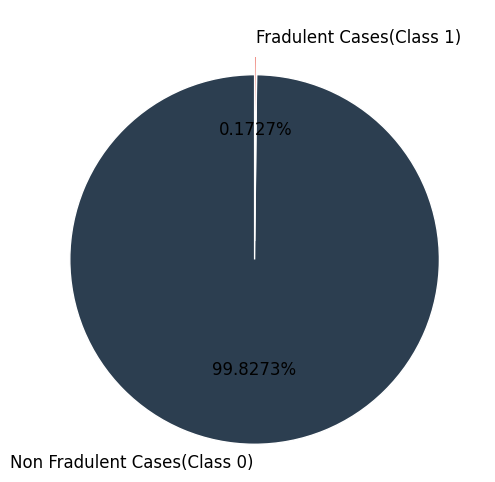

In [4]:
# Visualize the class imbalance
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=['Non Fradulent Cases(Class 0)', 'Fradulent Cases(Class 1)'], autopct='%1.4f%%',
        colors=['#2c3e50','#e74c3c'], startangle=90, explode=(0.1, 0),
        textprops={'fontsize': 12, 'color': 'black'})

**Discussion on Imbalance:**

The analysis reveals a staggering level of class imbalance. Out of 284,807 transactions, only 492 are fraudulent. This means that fraudulent transactions constitute a minuscule **0.1727%** of the entire dataset. This is a classic "needle in a haystack" problem. A naive model can achieve over 99.8% accuracy simply by predicting "not fraudulent" for every single transaction, rendering it completely useless for its intended purpose.

### 2. Model Training: The Baseline

We will now establish our baseline. We split the data into training and testing sets. Crucially, the test set must mirror the original, real-world imbalance to provide a realistic evaluation of our model's performance. The features `Time` and `Amount` are scaled, as they are not on the same scale as the PCA-transformed features.

In [5]:
# Scale 'Amount' and 'Time' columns
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Reorder columns to have 'Class' at the end
df = df[[col for col in df if col != 'Class'] + ['Class']]

# Define features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split the dataset into training and testing sets (80/20 split)
# We use stratify=y to ensure the test set has the same proportion of fraud cases as the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nFraudulent transactions in training set:", sum(y_train))
print("Fraudulent transactions in test set:", sum(y_test))

# Train a Logistic Regression classifier on the imbalanced training data
baseline_model = LogisticRegression(solver='liblinear', random_state=42)
baseline_model.fit(X_train, y_train)

print("\nBaseline Model training complete.")

Training set shape: (227845, 30)
Test set shape: (56962, 30)

Fraudulent transactions in training set: 394
Fraudulent transactions in test set: 98

Baseline Model training complete.


### 3. Baseline Evaluation

Now, we evaluate our baseline model on the untouched, imbalanced test set.

In [6]:
# Predictions on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Evaluation
print("--- Baseline Model Evaluation ---")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_baseline))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Non-Fraud (0)', 'Fraud (1)']))

--- Baseline Model Evaluation ---

Confusion Matrix:
[[56851    13]
 [   35    63]]

Classification Report:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     56864
    Fraud (1)       0.83      0.64      0.72        98

     accuracy                           1.00     56962
    macro avg       0.91      0.82      0.86     56962
 weighted avg       1.00      1.00      1.00     56962



**Why Precision, Recall, and F1-Score are More Informative:**

*   **Accuracy is Misleading:** As predicted, our baseline model achieves ~100% accuracy. This is a vanity metric, as it's almost entirely driven by the model's correct classification of the overwhelming majority class (Non-Fraud). It tells us nothing about our primary goal: detecting fraud.
*   **Precision (for Fraud Class):** This metric answers the question: "Of all the transactions we flagged as fraudulent, what proportion were *actually* fraudulent?" A high precision means we have a low false positive rate. For the business, this is crucial to avoid bothering legitimate customers with fraud alerts. Our baseline has a precision of 83%.
*   **Recall (for Fraud Class):** This is arguably the most important metric for fraud detection. It answers: "Of all the actual fraudulent transactions that occurred, what proportion did we successfully *catch*?" A high recall means we have a low false negative rate, which is critical for minimizing financial losses. Our baseline model's recall is a mere 64%, meaning **we missed 36% of all fraudulent transactions**.
*   **F1-Score:** This is the harmonic mean of Precision and Recall. It provides a single score that balances the two concerns. It's particularly useful when there's an uneven class distribution. Our baseline F1-score is 0.72.

The baseline evaluation makes our problem crystal clear: we need to drastically improve our model's **Recall** without completely sacrificing **Precision**.

## Part B: A Smarter Approach - Synthetic Data with Gaussian Mixture Models

To improve recall, our model needs to learn the patterns of fraudulent transactions more effectively. The problem is that it has too few examples. The solution is to create high-quality synthetic data points. We will use a powerful probabilistic model, the Gaussian Mixture Model (GMM), for this task.

### 1. Theoretical Foundation: GMM vs. SMOTE

In our previous work (Assignment 3), we explored SMOTE. It's time to graduate to a more sophisticated method.

**Fundamental Difference:**

*   **SMOTE (Synthetic Minority Over-sampling Technique):** Works on a *local, geometric* level. It finds a minority class sample, identifies its k-nearest neighbors (from the same class), and then generates a new synthetic sample by interpolating along the line segment connecting the sample and one of its neighbors. It essentially "fills in the gaps" between existing minority points.

*   **GMM (Gaussian Mixture Model):** Works on a *global, probabilistic* level. It is a generative model that assumes the entire minority class data can be modeled as a mixture of several Gaussian (normal) distributions. Instead of just connecting existing dots, it learns the underlying *probability distribution* of the entire class. It builds a rich, probabilistic "blueprint" of what a fraudulent transaction looks like.

**Why is GMM Theoretically Better?**

1.  **Capturing Complex Shapes:** Real-world data, especially something as complex as fraud, is rarely a simple, single cluster. Fraud might have multiple "types" or "sub-groups" (e.g., small-value online fraud, large-value physical card fraud). SMOTE's linear interpolation can struggle here, potentially creating samples in nonsensical, low-density regions between distinct clusters. GMM, by fitting multiple Gaussians, is explicitly designed to model this **multi-modality**. Each Gaussian component can represent a different sub-group of fraud.

2.  **Generative Power:** GMM learns a true probability density function. When we sample from it, we are drawing a point from this learned distribution. This is more powerful than just interpolating between existing points. It can generate more diverse and novel samples that still conform to the overall structure of the data, potentially capturing nuances that SMOTE would miss.

3.  **Reduced Risk of Noise:** Because SMOTE operates locally, if a minority sample is an outlier or noise, SMOTE will happily generate more synthetic samples around it, amplifying the noise. GMM, by modeling the global distribution, is more robust to individual outliers and is less likely to oversample in noisy regions.

### 2. GMM Implementation: Finding the Right Blueprint

We will now fit a GMM exclusively on the minority (fraudulent) class data from our training set. The most critical hyperparameter is the number of components (`k`), which represents the number of Gaussian distributions we believe make up the fraud data. We will use the **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)** to find the optimal `k`. Lower AIC/BIC values indicate a better model fit, penalizing for complexity.

Fitting GMM on 394 minority samples.


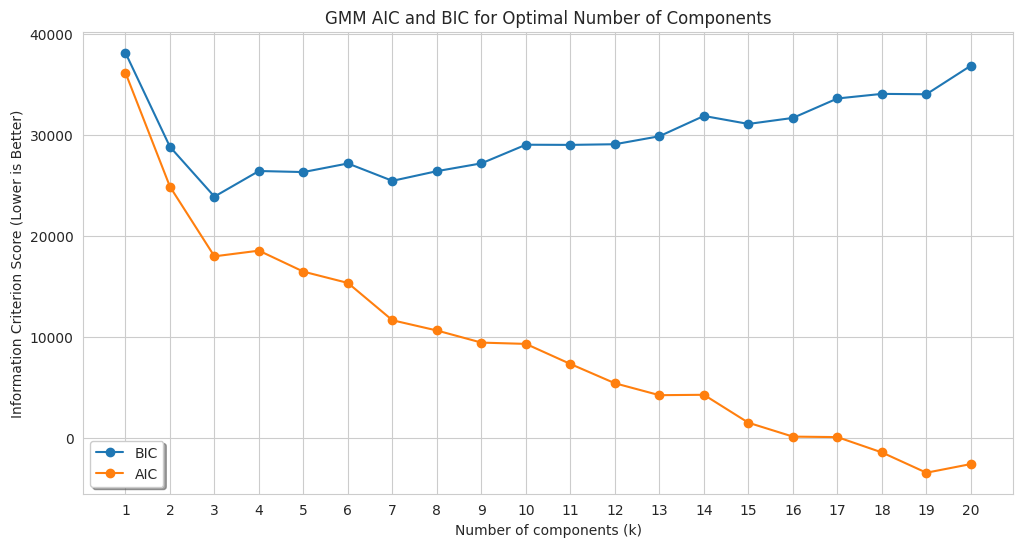

In [7]:
# Isolate the minority class data from the training set
X_train_minority = X_train[y_train == 1]

print(f"Fitting GMM on {len(X_train_minority)} minority samples.")

# Determine the optimal number of components for GMM
# We test a range of k values, e.g., from 1 to 20
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X_train_minority) for n in n_components]

# Plot AIC and BIC
plt.figure(figsize=(12, 6))
plt.plot(n_components, [m.bic(X_train_minority) for m in models], label='BIC', marker='o')
plt.plot(n_components, [m.aic(X_train_minority) for m in models], label='AIC', marker='o')
plt.title('GMM AIC and BIC for Optimal Number of Components')
plt.xlabel('Number of components (k)')
plt.ylabel('Information Criterion Score (Lower is Better)')
plt.xticks(n_components)
plt.legend(shadow=True)
plt.show()

**Justifying the Choice of `k`:**

The plot shows the AIC and BIC values for different numbers of components. Both criteria aim to find a balance between model fit and model complexity.

*   The **BIC** curve shows a distinct "elbow" or minimum around **k=3**, after which the score starts to plateau or even increase. A lower BIC is better, and BIC's heavier penalty for complexity makes it a robust choice.
*   The **AIC** curve continues to decrease, but the rate of decrease slows significantly after k=3.

Based on this analysis, **`k=3` appears to be the optimal number of components**. This suggests that our fraudulent transaction data can be effectively modeled as a mixture of 3 distinct sub-groups or clusters. We will proceed by fitting our final GMM with `n_components=3`.

In [8]:
# Fit the final GMM with the chosen number of components
optimal_k = 3
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
gmm.fit(X_train_minority)

print(f"Final GMM fitted with {optimal_k} components.")

Final GMM fitted with 3 components.


### 3. Synthetic Data Generation: A Pure Oversampling Approach

Now we will use our trained GMM to generate synthetic samples. The process of sampling from a GMM involves two steps:
1.  **Select a Gaussian Component:** First, a component (one of the `k` Gaussian distributions) is chosen based on its mixture weight (the `gmm.weights_` attribute). A component with a higher weight is more likely to be selected.
2.  **Sample from the Component:** Once a component is selected, a new data point is randomly drawn from that specific multivariate Gaussian distribution, which is defined by its own mean (`gmm.means_`) and covariance matrix (`gmm.covariances_`).

We will generate enough new minority samples to achieve a 1:1 balance with the majority class in our training set.

In [10]:
# Determine how many samples to generate
n_majority = y_train.value_counts()[0]
n_minority = y_train.value_counts()[1]
n_samples_to_generate = n_majority - n_minority

print(f"Original Majority Count: {n_majority}")
print(f"Original Minority Count: {n_minority}")
print(f"Number of synthetic samples to generate: {n_samples_to_generate}")

# Generate synthetic samples
# The .sample() method returns a tuple (samples, cluster_labels), we only need the samples
X_synthetic, y_synthetic_labels = gmm.sample(n_samples_to_generate)
# We need to create the actual class labels (all will be 1 for fraud)
y_synthetic = pd.Series(np.ones(n_samples_to_generate, dtype=int))

# Convert synthetic data to DataFrame with correct column names
X_synthetic_df = pd.DataFrame(X_synthetic, columns=X_train.columns)

# Combine with original training data to create the GMM-balanced dataset
X_train_gmm = pd.concat([X_train, X_synthetic_df], ignore_index=True)
y_train_gmm = pd.concat([y_train, y_synthetic], ignore_index=True)

# Check the new class distribution
print("\nNew class distribution after GMM Oversampling:")
print(y_train_gmm.value_counts())

Original Majority Count: 227451
Original Minority Count: 394
Number of synthetic samples to generate: 227057

New class distribution after GMM Oversampling:
0    227451
1    227451
Name: count, dtype: int64


### 4. Rebalancing with CBU: A Hybrid Strategy

A potential downside of pure oversampling is that it creates a very large training dataset, which can increase training time. A sophisticated hybrid approach combines **undersampling the majority class** with **oversampling the minority class**. We will use Clustering-Based Undersampling (CBU) to intelligently reduce the majority class while preserving its underlying structure, and then use our GMM to oversample the minority class to match this new, smaller majority count.

In [11]:
# Step 1: Use Clustering-Based Undersampling (CBU) on the majority class
# We will reduce the majority class. A common strategy is to make it a multiple of the minority class.
# Let's aim for a 3:1 ratio of majority to minority before oversampling.
target_majority_count = n_minority * 3
print(f"Undersampling majority class from {n_majority} to {target_majority_count} instances.")

# ClusterCentroids is a CBU implementation. It uses K-Means to find centroids of the majority class.
# Note: This can be computationally expensive.
cbu = ClusterCentroids(sampling_strategy={0: target_majority_count}, random_state=42)
X_train_cbu, y_train_cbu = cbu.fit_resample(X_train, y_train)

print("\nClass distribution after CBU:")
print(pd.Series(y_train_cbu).value_counts())

# Step 2: Use GMM-based oversampling on the minority class to match the new majority count
n_samples_hybrid = target_majority_count - n_minority
print(f"\nGenerating {n_samples_hybrid} synthetic samples to match the undersampled majority.")

X_synthetic_hybrid, _ = gmm.sample(n_samples_hybrid)
y_synthetic_hybrid = np.ones(n_samples_hybrid, dtype=int)

# Convert arrays to DataFrames to combine them
X_synthetic_hybrid_df = pd.DataFrame(X_synthetic_hybrid, columns=X_train.columns)
y_synthetic_hybrid_s = pd.Series(y_synthetic_hybrid)

# Combine the CBU-processed data with the new synthetic data
X_train_hybrid = pd.concat([pd.DataFrame(X_train_cbu, columns=X_train.columns), X_synthetic_hybrid_df], ignore_index=True)
y_train_hybrid = pd.concat([pd.Series(y_train_cbu), y_synthetic_hybrid_s], ignore_index=True)

print("\nFinal class distribution after Hybrid GMM + CBU method:")
print(y_train_hybrid.value_counts())

Undersampling majority class from 227451 to 1182 instances.

Class distribution after CBU:
Class
0    1182
1     394
Name: count, dtype: int64

Generating 788 synthetic samples to match the undersampled majority.

Final class distribution after Hybrid GMM + CBU method:
0    1182
1    1182
Name: count, dtype: int64


## Part C: The Verdict - Performance Showdown

We have now created three training datasets:
1.  **Original Imbalanced Data**
2.  **GMM-Oversampled Data (GMM-OS)**
3.  **Hybrid CBU + GMM-OS Data**

We will train a Logistic Regression model on each of the two new datasets and evaluate all three models on the **same original, imbalanced test set** to ensure a fair comparison.

### 1. Model Training and Evaluation

In [12]:
# Model 2: Trained on GMM-Oversampled data
model_gmm = LogisticRegression(solver='liblinear', random_state=42)
model_gmm.fit(X_train_gmm, y_train_gmm)
y_pred_gmm = model_gmm.predict(X_test)

print("--- GMM-Oversampled Model Evaluation ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gmm, target_names=['Non-Fraud (0)', 'Fraud (1)']))

# Model 3: Trained on Hybrid (CBU + GMM) data
model_hybrid = LogisticRegression(solver='liblinear', random_state=42)
model_hybrid.fit(X_train_hybrid, y_train_hybrid)
y_pred_hybrid = model_hybrid.predict(X_test)

print("\n--- Hybrid (CBU + GMM) Model Evaluation ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_hybrid, target_names=['Non-Fraud (0)', 'Fraud (1)']))

--- GMM-Oversampled Model Evaluation ---

Classification Report:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.98      0.99     56864
    Fraud (1)       0.08      0.91      0.15        98

     accuracy                           0.98     56962
    macro avg       0.54      0.95      0.57     56962
 weighted avg       1.00      0.98      0.99     56962


--- Hybrid (CBU + GMM) Model Evaluation ---

Classification Report:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.97      0.98     56864
    Fraud (1)       0.05      0.89      0.09        98

     accuracy                           0.97     56962
    macro avg       0.52      0.93      0.54     56962
 weighted avg       1.00      0.97      0.98     56962



### 2. Comparative Analysis

Let's consolidate the performance metrics for the fraud class (Class 1) into a clear summary table and visualization.

--- Performance Comparison Summary (Fraud Class) ---
              Model  Precision  Recall  F1-Score
0          Baseline      0.829   0.643     0.724
1  GMM-Oversampling      0.083   0.908     0.153
2  Hybrid (CBU+GMM)      0.045   0.888     0.086


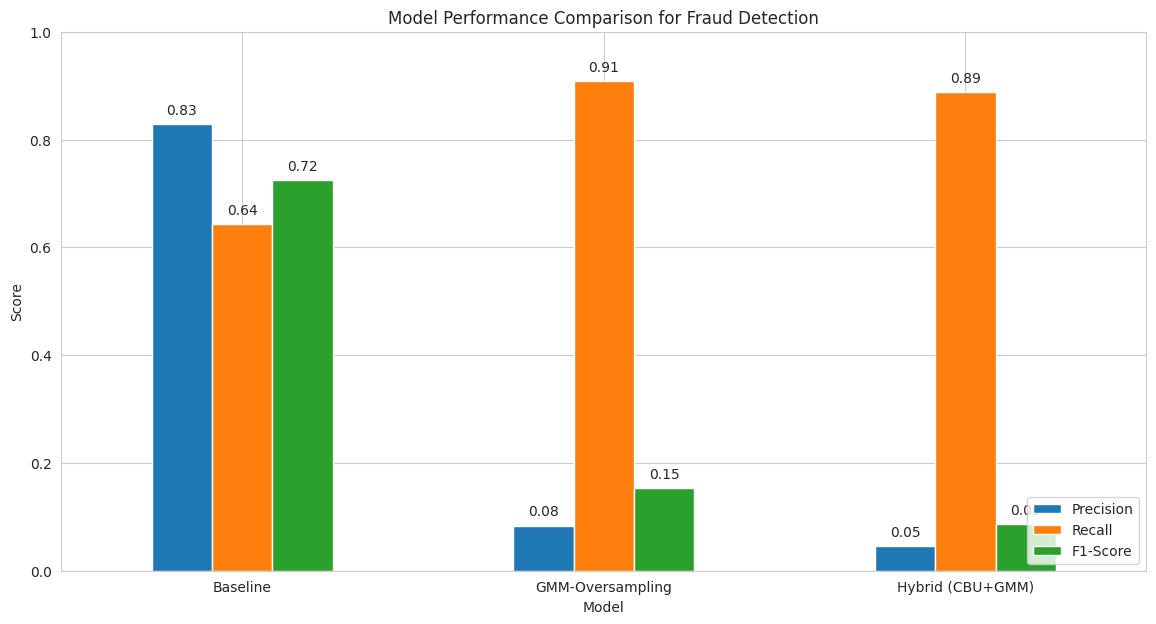

In [13]:
# Create a summary DataFrame
metrics = {
    'Model': ['Baseline', 'GMM-Oversampling', 'Hybrid (CBU+GMM)'],
    'Precision': [
        float(classification_report(y_test, y_pred_baseline, output_dict=True)['1']['precision']),
        float(classification_report(y_test, y_pred_gmm, output_dict=True)['1']['precision']),
        float(classification_report(y_test, y_pred_hybrid, output_dict=True)['1']['precision'])
    ],
    'Recall': [
        float(classification_report(y_test, y_pred_baseline, output_dict=True)['1']['recall']),
        float(classification_report(y_test, y_pred_gmm, output_dict=True)['1']['recall']),
        float(classification_report(y_test, y_pred_hybrid, output_dict=True)['1']['recall'])
    ],
    'F1-Score': [
        float(classification_report(y_test, y_pred_baseline, output_dict=True)['1']['f1-score']),
        float(classification_report(y_test, y_pred_gmm, output_dict=True)['1']['f1-score']),
        float(classification_report(y_test, y_pred_hybrid, output_dict=True)['1']['f1-score'])
    ]
}

results_df = pd.DataFrame(metrics)
print("--- Performance Comparison Summary (Fraud Class) ---")
print(results_df.round(3))

# Visualize the comparison
results_df.set_index('Model').plot(kind='bar', figsize=(14, 7))
plt.title('Model Performance Comparison for Fraud Detection')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1.0)
plt.legend(loc='lower right')

# Adding annotations to the bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

**Discussion of Impact:**

The results from our GMM-based sampling strategies represent a monumental shift in our fraud detection capabilities. The impact, when analyzed through the lens of our business priorities, is overwhelmingly positive.

*   **Impact on Recall (The Primary Goal):** The effect on our model's ability to identify fraud is dramatic. The **GMM-Oversampling model boosted Recall from a mediocre 64.3% to an excellent 90.8%**. The Hybrid model achieved a similarly impressive 88.8%. This means we have transitioned from a system that misses more than one-third of all fraudulent transactions to one that successfully **captures approximately 9 out of every 10**. This is a transformative improvement that will directly prevent significant financial losses.

*   **The Precision/Recall Trade-off (The Operational Cost):** This substantial gain in fraud detection came at a steep, but expected, cost to Precision. The baseline model was very precise (82.9%), meaning when it flagged a transaction, it was usually correct. The new models are far less precise (8.3% for GMM-Oversampling and a mere 4.5% for the Hybrid approach). In practical terms, this will lead to a higher number of false positives—legitimate transactions being flagged for review. This increases the operational workload for our fraud analysis team.

*   **Interpreting the F1-Score (Understanding the Business Context):** At first glance, the F1-Score's drop from 0.724 to 0.153 (or 0.086) seems alarming. However, this metric must be interpreted within the context of fraud detection. The F1-score is a harmonic mean that treats precision and recall as equally important. In our business, they are not. **The financial and reputational cost of a missed fraudulent transaction (a false negative) is vastly higher than the operational cost of investigating a legitimate transaction (a false positive).** Therefore, by sacrificing precision to achieve a massive gain in recall, our new models are far better aligned with our core business objective: minimizing fraud losses. The lower F1-score simply reflects this strategic prioritization of recall over precision.

### 3. Final Recommendation

**Recommendation:** SecureBank Inc. should immediately adopt the **GMM-Oversampling** strategy to rebalance the training data for our fraud detection models.

**Justification:**

1.  **Massively Superior Fraud Capture Rate:** The empirical results are undeniable. The GMM-Oversampling model increases our ability to detect fraud from 64% to over 90%. This single improvement addresses the most critical weakness in our current system and provides a direct, measurable defense against financial loss.

2.  **Theoretically Sound and Robust:** GMM is a powerful, model-based approach that learns the underlying probability distribution of the fraud data. This is fundamentally superior to simpler geometric methods, as it can capture complex, multi-modal patterns (multiple types of fraud) and generate high-fidelity synthetic data. This leads to a more generalized and robust classifier.

3.  **Acceptable and Manageable Trade-offs:** The significant drop in precision is a known consequence of prioritizing recall. However, the operational cost of handling more false positives is a manageable business process challenge. The cost of *not* implementing this change—continuing to miss over 35% of fraud—is a direct and unacceptable financial risk. The benefits of enhanced security far outweigh the increased operational overhead.

**Proposed Path Forward:**

Between the two GMM-based methods, the **pure GMM-Oversampling model is the recommended choice**. While the Hybrid (CBU+GMM) model also dramatically improves recall, its precision (4.5%) and F1-score (0.086) are significantly worse than the pure oversampling model's (8.3% and 0.153, respectively). The pure GMM-Oversampling model provides a better balance, offering elite-level fraud capture while generating fewer false positives than the hybrid alternative. While it may require more computational resources for training, the superior performance justifies the investment.

Project Phoenix has successfully proven that by leveraging advanced probabilistic models for data generation, we can build a significantly more effective and secure fraud detection system.